In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn import decomposition
import pandas as pd


In [2]:
digits = load_digits()
X = digits["data"]/255.
Y = digits["target"]
print(X.shape)

(1797, 64)


# Question 4: Implementation of NMF

In [3]:
class MyNMF:
    
    def __init__(self, max_iter = 1000, num_comp = None):
        self.max_iter = max_iter
        self.num_comp = num_comp
        
        self.h = None
        self.w = None
        
    def fit(self, X):
        
        self.num_comp = X.shape[1] if self.num_comp == None else self.num_comp
        
        X = np.asmatrix(X)
        
        self.w = np.asmatrix(np.abs(np.random.randn(X.shape[0], self.num_comp)))
        self.h = np.asmatrix(np.abs(np.random.randn(self.num_comp, X.shape[1])))
        
        counter = 0
        while counter < self.max_iter:
            
            self.h = np.matrix(np.array(self.h) * np.array(np.transpose(self.w) * X) / np.array(np.transpose(self.w) * self.w * self.h).clip(1e-8, np.inf))
            self.w = np.matrix(np.array(self.w) * np.array(X * np.transpose(self.h)) / np.array(self.w * self.h * np.transpose(self.h)).clip(1e-8, np.inf))
            
            counter += 1
            
        

In [4]:
nmf1 = MyNMF(num_comp=30)
nmf1.fit(X)

w1 = nmf1.w
h1 = nmf1.h

In [5]:
nmf2 = decomposition.NMF(max_iter=1000, n_components=30)
w2 = nmf2.fit_transform(X)
h2 = nmf2.components_

## Comparison

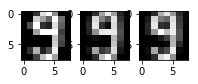

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(3, 1))

rand_number = np.random.randint(len(X))
    
ax[0].imshow(X[rand_number].reshape(8, 8), cmap='gray')
rec1 = np.dot(w1[rand_number], h1)
ax[1].imshow(rec1.reshape(8, 8), cmap='gray')
rec2 = np.dot(w2[rand_number], h2)
ax[2].imshow(rec2.reshape(8, 8), cmap='gray')
    
plt.show()

As you can see, both classifiers perform similiar.

# Question 5: Recommender

In [9]:
ratings_cols = ['user id', 'movie id', 'rating', 'timestamp']
movies_cols =['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL ', 'unknown', 'Action',
'Adventure','Animation','Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film- Noir', 'Horror',
'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War','Western']
users_cols =['user id', 'age', 'gender', 'occupation', 'zipcode']

users = pd.read_csv('ml-100k/u.user',sep = '|', names = users_cols , encoding ='latin-1')
movies = pd. read_csv ('ml-100k/u.item',sep = '|', names = movies_cols , encoding = 'latin-1')
ratings = pd . read_csv ( 'ml-100k/u.data',sep = '\t', names = ratings_cols , encoding = 'latin-1')

ratings.head()


,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
fill_value = 0
rat_df = ratings.pivot( index = 'user id', columns = 'movie id', values = 'rating').fillna(fill_value)
rat_df.head()

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## NMF Recommender

In [11]:
x_r = rat_df.as_matrix()
sparsity = 1 - np.count_nonzero(x_r)/(x_r.shape[0] * x_r.shape[1])
print(sparsity)

0.9369533063577546


In [12]:
def recommend_movies(rec, user_id, ratings, n = 5):
    # reconstructed ratings of user
    user_rec = rec.loc[user_id].as_matrix()
    # ids of already rated
    have_seen = ratings['movie id'][ratings['user id'] == user_id].as_matrix()
    
    # lowest one is in front
    sorted_by_rating = np.argsort(user_rec)
    # only those which have not been rated by user
    mask = np.logical_not(np.in1d(rec.columns[sorted_by_rating], have_seen))
    # apply sorting and mask
    best_ids = rec.columns[sorted_by_rating][mask]
    # return number of desired recommendations
    return best_ids[-n:]


### Stability of Recommender

In [13]:
recomments = []

for _ in range(50):
    comender = decomposition.NMF(max_iter=5000, n_components=25)
    w3 = comender.fit_transform(x_r)
    h3 = comender.components_
    rec = np.dot(w3, h3)
    rec_df = pd.DataFrame(data = rec, columns = rat_df.columns, index = rat_df.index)
    
    recomments.append(recommend_movies(rec_df, 2, ratings))
recomments = np.array(recomments)

In [14]:
recommended_ids, occurences = np.unique(recomments, return_counts=True)

In [15]:
for i, recommended_id in enumerate(recommended_ids):
    print('Movie id {:5d}: {:3d} times'.format(recommended_id, occurences[i]))

Movie id     9:  50 times
Movie id    15:   4 times
Movie id   116:  47 times
Movie id   124:  50 times
Movie id   137:  50 times
Movie id   181:  49 times


The recommender is relatively stable against random initialisation.

### Analysis of H

In [16]:
comender = decomposition.NMF(max_iter=5000, n_components=25)
w3 = comender.fit_transform(x_r)
h3 = comender.components_
rec_sparsity = 1 - np.count_nonzero(rec)/(rec.shape[0] * rec.shape[1])
print(rec_sparsity)

0.1243665383456295


In [17]:
rec_df = pd.DataFrame(data = rec, columns = rat_df.columns, index = rat_df.index)
rec_df.head()

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,4.488337,2.010705,1.322843,2.835408,0.990443,0.585966,4.048590,3.050422,3.098791,1.902272,...,0.003160,0.040722,0.009260,0.006173,0.019730,0.000404,0.001213,0.000809,0.042291,0.055634
2,2.242333,0.017193,0.077805,0.046189,0.084185,0.373892,1.119614,0.411466,2.879184,0.821143,...,0.001789,0.000000,0.005848,0.003899,0.008658,0.008152,0.024457,0.016305,0.000000,0.000000
3,0.234201,0.033120,0.048310,0.094091,0.004501,0.096360,0.111447,0.224431,0.092282,0.075737,...,0.001070,0.000049,0.004019,0.002679,0.002583,0.007111,0.021334,0.014222,0.000068,0.000786
4,0.836443,0.024352,0.050013,0.103853,0.056310,0.000263,0.262536,0.137048,0.085587,0.002447,...,0.000452,0.000091,0.000000,0.000000,0.001790,0.003851,0.011552,0.007701,0.000147,0.001424
5,3.737589,1.257290,0.132148,1.678486,0.876023,0.000000,2.828462,1.920054,0.048177,0.445339,...,0.000000,0.000843,0.006967,0.004645,0.000135,0.000000,0.000000,0.000000,0.006420,0.006276


In [18]:
def get_highest_rated_category(cat_names, movies, movie_vector):
    
    # this gets the percentage of likes for all categories on a specific movie vector
    # movie vector contains the ratings
    
    total_rates = {}
    tot_sum = 0
    for cat in cat_names:
        total_rates[cat] = np.sum(movie_vector * movies[cat].as_matrix())/len(movie_vector)
        tot_sum += total_rates[cat]
    for key in total_rates:
        # normalise
        total_rates[key] /= tot_sum
    return total_rates

def get_rates_for_category(cat_names, movies, h):
    results = []
    # get for each vector the distribution
    for movie_vector in h:
        rates_cat = get_highest_rated_category(cat_names, movies, movie_vector)
        results.append([rates_cat[cat] for cat in cat_names])
    return np.array(results)

In [19]:
comp = get_rates_for_category(movies_cols[5:], movies, h3)

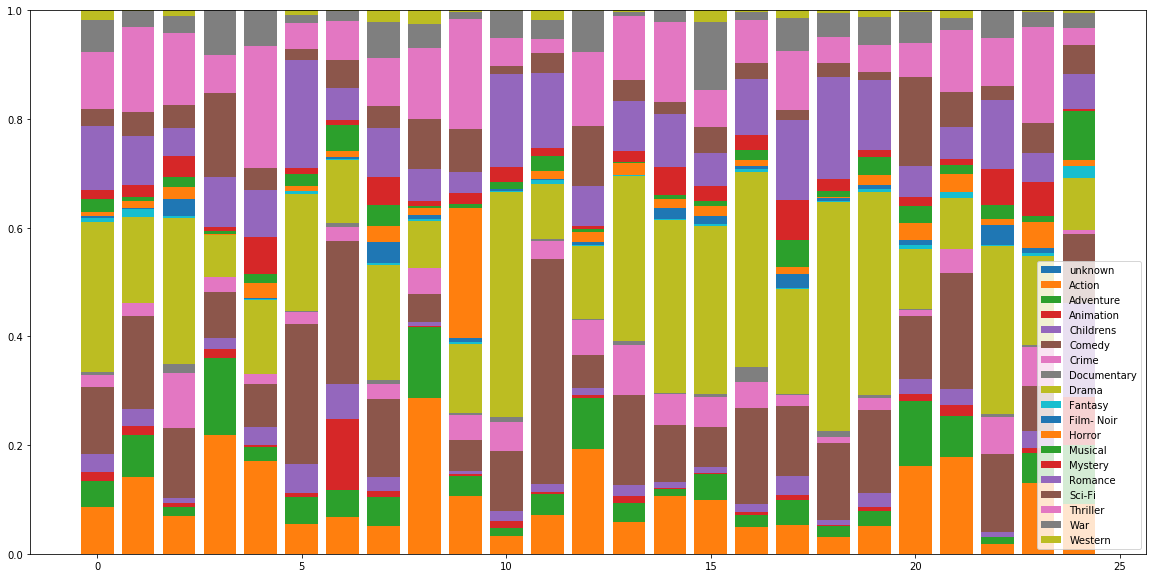

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
last = np.zeros(comp.shape[0])
for i in range(comp.shape[1]):
    ax.bar(np.arange(comp.shape[0]), comp[:,i], bottom = last, label=movies_cols[5 + i])
    last += comp[:, i]

ax.legend()
plt.show()

There are some vectors, which can be associated with a category. For example vector 9 (zero-indexing) is related with Horror, vector 11 with Comedy and vector 24 with Musicals.